In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi

Sun May  7 16:10:51 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8    12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import sklearn
import numpy as np
from glob import glob
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.pipeline import Pipeline

import string
from os import listdir
from nltk.corpus import stopwords
from nltk.corpus import stopwords
from pickle import dump
from string import punctuation

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
#load data
#df = pd.read_csv('/content/drive/MyDrive/Bangla Datasets/FINAL_BANGLA_DB/bengali_Toxic_balance.csv', encoding='UTF-8')
#df = pd.read_csv('/content/drive/MyDrive/Bangla Datasets/FINAL_BANGLA_DB/bengali_Toxic_balance_upload.csv')
#df = pd.read_csv('/content/drive/MyDrive/Bangla Datasets/FINAL_BANGLA_DB/bengali_Toxic_balance_upload_with_augment.csv')
df = pd.read_csv('/content/drive/MyDrive/Dataset/last_dataset.csv')
#reset index
#df.set_index('id', inplace = True)
df.head()

,comment_text,toxic,threat,obscene,religious
0,"অয় ভাই,লজ্জাবতী লতা_____ হেতেরে গে দিয়া চুম্মা।",1,0,1,0
1,"অসভ্য,",1,0,0,0
2,অসুবিধা নাই। নিজেরা দুর্নিতি করে সহযোগিদের ফা...,1,0,1,0
3,"অারিপ্পার পুটকিতে বাল গজুক অার নাই গজুক, অাজ ...",1,0,1,0
4,আইভি সাথে নির্বাচন করতে হলে খালেদা জিয়া লাগবে...,1,0,1,0


In [ ]:
filter = df["comment_text"] != ""
df = df[filter]
df = df.dropna()

In [ ]:
#df = df.drop(['Toxic', 'NonToxic'], axis=1 )
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,comment_text,toxic,threat,obscene,religious
0,ধর্ষন করা,0,0,1,0
1,এই নাস্তিক খানকির পোলারে আর তসলিমা নাসরিনরে যদ...,0,0,0,1
2,মূর্খামির পরিচয়,0,0,1,0
3,"বউয়ের দুধ তোমার সন্তানের জন্য, তোমার জন্য না",1,0,1,0
4,যখন শিক্ষকদের লাঞ্ছিত করে হত্যা করে তখন প্রতিব...,1,0,0,1


In [ ]:
df = df.loc[((df['toxic'] == 1) | (df['threat'] == 1) | (df['obscene'] ==1) | (df['religious'] == 1))]

In [ ]:
df = df.sample(frac=1).reset_index(drop=True)
df.head(5)

,comment_text,toxic,threat,obscene,religious
0,সাফা কবির এর জন্য সামান্য কিছু উপহার। লাথি+জ...,0,1,0,0
1,আচ্ছা তুই কি তোর বাবা আর মায়ের চুদাচুদি দেখেছি...,1,0,1,0
2,সাফারেওরে জুতা পারো,0,1,0,0
3,নাস্তিক তুইতর নাটক বয়কট করলামআর তর নাটক দেখবো ...,0,0,0,1
4,ওকে কেউই বিয়ে করবে না এই নাস্তিক,0,0,0,1


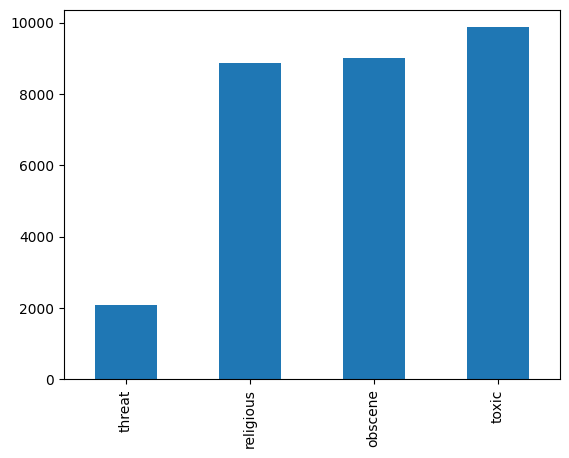

In [ ]:
LABEL_COLUMNS = df.columns.tolist()[1:]
df[LABEL_COLUMNS].sum().sort_values().plot(kind="bar");

In [ ]:
df[LABEL_COLUMNS].sum()

toxic        9870
threat       2100
obscene      9013
religious    8880
dtype: int64

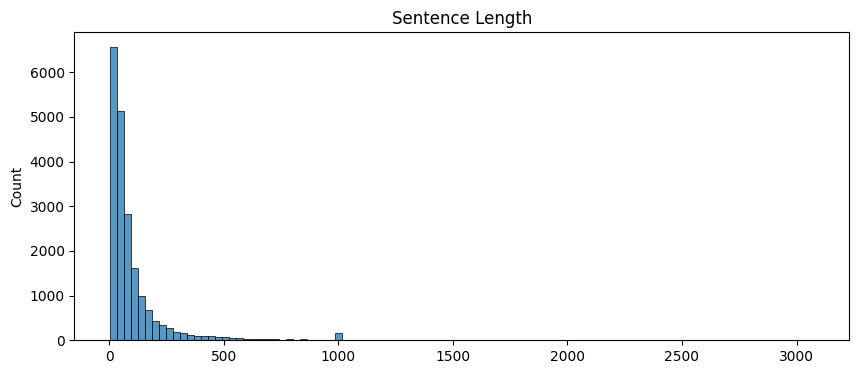

In [ ]:
#need equal length sentences
#plot hist of sentence length
plt.figure(figsize=(10, 4))
sns.histplot([len(s) for s in df.comment_text], bins=100)
plt.title('Sentence Length')
plt.show()

In [ ]:
stop_word_list = (stopwords.words('bengali'))

In [ ]:
import string

# turn a doc into clean tokens
def clean_doc(doc):
	# split into tokens by white space
	tokens = doc.split()

	# remove punctuation from each token
	table = str.maketrans('', '', string.punctuation)
	tokens = [w.translate(table) for w in tokens]

	# remove remaining tokens that are not alphabetic
	tokens = [word for word in tokens if not word.isalpha()]

	# filter out stop words
	stop_words = stop_word_list
	tokens = [w for w in tokens if not w in stop_words]

	# filter out short tokens
	tokens = [word for word in tokens if len(word) > 1]
	tokens = ' '.join(tokens)
	return tokens

In [ ]:
df['comment_text'] = df.comment_text.apply(clean_doc)

In [ ]:
sample_row = df.iloc[125]
sample_comment = sample_row.comment_text
sample_labels = sample_row[LABEL_COLUMNS]

print(sample_comment)
print(sample_labels.to_dict())

আচ্ছা মানলাম নাসির ভায়ের দোষ আপু কেমন মেয়ে প্রেমের ১৪ দিনের মাথায় চুদতে
{'toxic': 1, 'threat': 0, 'obscene': 1, 'religious': 0}


**Train Test Split**

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [ ]:
!pip3 install iterative-stratification

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
X = df['comment_text']

In [ ]:
X

0            সাফা কবির সামান্য উপহার। লাথিজুতা মারি কপালে।
1        আচ্ছা তুই তোর বাবা মায়ের চুদাচুদি দেখেছিস থাকি...
2                                      সাফারেওরে জুতা পারো
3        নাস্তিক তুইতর নাটক করলামআর নাটক দেখবো নামেোসার...
4                                             বিয়ে নাস্তিক
                               ...                        
20279    টাংগাইল মাগি এনে পাবলিশ শুক্রবার দিনটাই মোসল্ল...
20280                                               বেইসশা
20281    পাগলের সাথে অামরাও পাগল চলবে ভূল খুবই মারাত্মক...
20282                                                 নুনু
20283                                  তোর মা চরিত্র খারাপ
Name: comment_text, Length: 20284, dtype: object

In [ ]:
y = df[['toxic', 'threat', 'obscene', 'religious']]
y

,toxic,threat,obscene,religious
0,0,1,0,0
1,1,0,1,0
2,0,1,0,0
3,0,0,0,1
4,0,0,0,1
...,...,...,...,...
20279,1,0,1,0
20280,1,0,0,0
20281,0,0,0,1
20282,0,0,1,0


In [ ]:
!pip install scikit-multilearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 9.2 MB/s eta 0:00:00


In [ ]:
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit

In [ ]:
X = X.to_numpy()
y = y.to_numpy()

In [ ]:
X

array(['সাফা কবির সামান্য উপহার। লাথিজুতা মারি কপালে।',
       'আচ্ছা তুই তোর বাবা মায়ের চুদাচুদি দেখেছিস থাকিস কেম্নে বিশ্বাস করিস তোর মায়ের স্বামী তোর বাবা',
       'সাফারেওরে জুতা পারো', ...,
       'পাগলের সাথে অামরাও পাগল চলবে ভূল খুবই মারাত্মক ভূল যেটা ক্ষমার অযোগ্যঅাল্লাহ তাদেরকে হেদায়েত দান করুক ইসলাম কুটুক্তি চলবে না। কোনা কাফেরের বাংলার মাটিতে ঠাই বাংলাদেশে এইগুলার বিচার কেনো অামাদের ধর্ম বাজে কথা জিব্বা কেটে',
       'নুনু', 'তোর মা চরিত্র খারাপ'], dtype=object)

In [ ]:
msss = MultilabelStratifiedShuffleSplit(n_splits=2, test_size=0.40, random_state=42)
for train_index, test_index in msss.split(X, y):
        x_train, x_test_temp = X[train_index], X[test_index]
        y_train, y_test_temp = y[train_index], y[test_index]

In [ ]:
msss = MultilabelStratifiedShuffleSplit(n_splits=2, test_size=0.4, random_state=42)
for val_index, test_index in msss.split(x_test_temp, y_test_temp):
        x_val, x_test = X[val_index], X[test_index]
        y_val, y_test = y[val_index], y[test_index]

In [ ]:
len(x_train), len(x_val), len(x_test)

(12198, 4849, 3237)

**BERT WORD EMBEDDING**

In [ ]:
%%capture
!pip3 install transformers
#!pip install transformers

In [ ]:
from transformers import AutoModelForPreTraining, AutoTokenizer
from transformers import BertTokenizer, TFBertModel

In [ ]:
# hyperparameters
max_length = 300
batch_size = 16
dev_size = 0.2

In [ ]:
import tensorflow as tf

In [ ]:
tokenizer = BertTokenizer.from_pretrained("sagorsarker/bangla-bert-base")

In [ ]:
X_input_ids_train = np.zeros((len(x_train), max_length))
X_attn_masks_train = np.zeros((len(x_train), max_length))

X_input_ids_dev = np.zeros((len(x_val), max_length))
X_attn_masks_dev = np.zeros((len(x_val), max_length))

X_input_ids_test = np.zeros((len(x_test), max_length))
X_attn_masks_test = np.zeros((len(x_test), max_length))

In [ ]:
from tqdm import tqdm
def preprocessing_dataset(df, ids, masks, tokenizer):
    for i, text in tqdm(enumerate(df)):
        tokenized_text = tokenizer.encode_plus(
            text,
            max_length=max_length,
            truncation=True,
            padding='max_length',
            add_special_tokens=True,
            return_tensors='tf'
        )
        ids[i, :] = tokenized_text.input_ids
        masks[i, :] = tokenized_text.attention_mask
    return ids, masks

In [ ]:
X_input_ids_tain, X_attn_masks_tain = preprocessing_dataset(x_train, X_input_ids_train, X_attn_masks_train, tokenizer)
X_input_ids_dev, X_attn_masks_dev = preprocessing_dataset(x_val, X_input_ids_dev, X_attn_masks_dev, tokenizer)
X_input_ids_test, X_attn_masks_test = preprocessing_dataset(x_test, X_input_ids_test, X_attn_masks_test, tokenizer)

12198it [00:18, 659.63it/s]
4849it [00:10, 481.76it/s]
3237it [00:03, 881.01it/s]


In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_input_ids_tain, X_attn_masks_tain, y_train))
dev_dataset = tf.data.Dataset.from_tensor_slices((X_input_ids_dev, X_attn_masks_dev, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_input_ids_test, X_attn_masks_test, y_test))

In [ ]:
def VulgarDatasetMapFunction(input_ids, attn_masks, labels):
    return {
        'input_ids': input_ids,
        'attention_mask': attn_masks
    }, labels

In [ ]:
train_dataset = train_dataset.map(VulgarDatasetMapFunction)
dev_dataset = dev_dataset.map(VulgarDatasetMapFunction)
test_dataset = test_dataset.map(VulgarDatasetMapFunction)

In [ ]:
train_dataset = train_dataset.shuffle(100).batch(batch_size)
dev_dataset = dev_dataset.shuffle(100).batch(batch_size)
test_dataset = test_dataset.shuffle(100).batch(batch_size)


In [ ]:
from tensorflow import keras

In [ ]:
from keras.optimizers import Adam

In [ ]:
# from keras.optimizers import adam_v2
# '''from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, GlobalMaxPool1D, Dropout
# from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
# from tensorflow.keras.models import Sequential'''


In [ ]:
from keras.layers import Input, LSTM, Dense, TimeDistributed, Activation, BatchNormalization, Dropout, Bidirectional
from keras.models import Sequential
from keras.layers import CuDNNLSTM

In [ ]:
!pip install Keras-Preprocessing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 5.7 MB/s eta 0:00:00


In [ ]:
import keras
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers import LSTM
from keras.layers.convolutional import MaxPooling1D
from keras.layers import concatenate
from pickle import load

from keras.layers import Conv1D, MaxPooling2D, Embedding, Dropout, LSTM, GRU, Bidirectional, TimeDistributed

In [ ]:
#Import necessary libraries
# demonstration of calculating metrics for a neural network model using sklearn
import keras.backend as K
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from tensorflow.python.keras.metrics import Metric


def precision(y_true, y_pred):
    '''Calculates the precision, a metric for multi-label classification of
    how many selected items are relevant.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    '''Calculates the recall, a metric for multi-label classification of
    how many relevant items are selected.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

  #Customized the evaluation to analyse the model in terms of accuracy and mean value accuracy
def mean_pred(y_true, y_pred):
    return K.mean(y_pred)

def fbeta_score(y_true, y_pred, beta=1):
    '''Calculates the F score, the weighted harmonic mean of precision and recall.
    This is useful for multi-label classification, where input samples can be
    classified as sets of labels. By only using accuracy (precision) a model
    would achieve a perfect score by simply assigning every class to every
    input. In order to avoid this, a metric should penalize incorrect class
    assignments as well (recall). The F-beta score (ranged from 0.0 to 1.0)
    computes this, as a weighted mean of the proportion of correct class
    assignments vs. the proportion of incorrect class assignments.
    With beta = 1, this is equivalent to a F-measure. With beta < 1, assigning
    correct classes becomes more important, and with beta > 1 the metric is
    instead weighted towards penalizing incorrect class assignments.
    '''
    if beta < 0:
        raise ValueError('The lowest choosable beta is zero (only precision).')

    # If there are no true positives, fix the F score at 0 like sklearn.
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0.0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    bb = beta ** 2
    fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
    return fbeta_score

def auroc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc


def fmeasure(y_true, y_pred):
    '''Calculates the f-measure, the harmonic mean of precision and recall.
    '''
    return fbeta_score(y_true, y_pred, beta=1)


fscore = f1score = fmeasure

In [ ]:
from keras import initializers as initializers, regularizers, constraints
REG_PARAM = 1e-13
#l2_reg = regularizers.l2(REG_PARAM)

In [ ]:
def bert_model():
    bert_encoder = TFBertModel.from_pretrained("sagorsarker/bangla-bert-base")
    input_word_ids = tf.keras.Input(shape=(max_length,), dtype=tf.int32, name="input_ids")
    attn_masks = tf.keras.Input(shape=(max_length,), dtype=tf.int32, name="attention_mask")

    encoder_embedding_layer = bert_encoder(input_word_ids, attention_mask=attn_masks)[0]

    conv1 = Conv1D(filters=32, kernel_size=4, activation='leaky_relu')(encoder_embedding_layer)
    drop1 = Dropout(0.3)(conv1)
    pool1 = MaxPooling1D(pool_size=2)(drop1)
    flat1 = Flatten()(pool1)

    # channel 2
    #input2 = Input(shape=(length,))
    #embedding_layer_2 = embedding_layer(input2)
    conv2 = Conv1D(filters=32, kernel_size=6, activation='leaky_relu')(encoder_embedding_layer)
    drop2 = Dropout(0.3)(conv2)
    pool2 = MaxPooling1D(pool_size=2)(drop2)
    flat2 = Flatten()(pool2)

    # channel 3
    #input3 = Input(shape=(length,))
    #embedding_layer_3 = embedding_layer(input3)
    conv3 = Conv1D(filters=32, kernel_size=8, activation='leaky_relu')(encoder_embedding_layer)
    drop3 = Dropout(0.3)(conv3)
    pool3 = MaxPooling1D(pool_size=2)(drop3)
    flat3 = Flatten()(pool3)

    # merge
    CNN_layer = concatenate([flat1, flat2, flat3])

    # LSTM
    #x = embedding_layer(input3)
    LSTM_layer = LSTM(128, kernel_regularizer=regularizers.l2(1e-12))(encoder_embedding_layer)

    CNN_LSTM_layer = concatenate([LSTM_layer, CNN_layer])
    CNN_LSTM_layer = tf.keras.layers.Dropout(0.3)(CNN_LSTM_layer)
    # interpretation
    dense1 = Dense(80, activation='leaky_relu')(CNN_LSTM_layer)
    output = Dense(4, activation='sigmoid')(dense1)

    # Finally building model
    model = keras.Model(inputs=[input_word_ids, attn_masks], outputs=output)


    return model

In [ ]:
model = bert_model()

Some layers from the model checkpoint at sagorsarker/bangla-bert-base were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at sagorsarker/bangla-bert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              optimizer=tf.keras.optimizers.Adam(1e-5),
              metrics=['accuracy', fmeasure, precision, recall])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 300)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 300)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  164396544   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 300,                                           

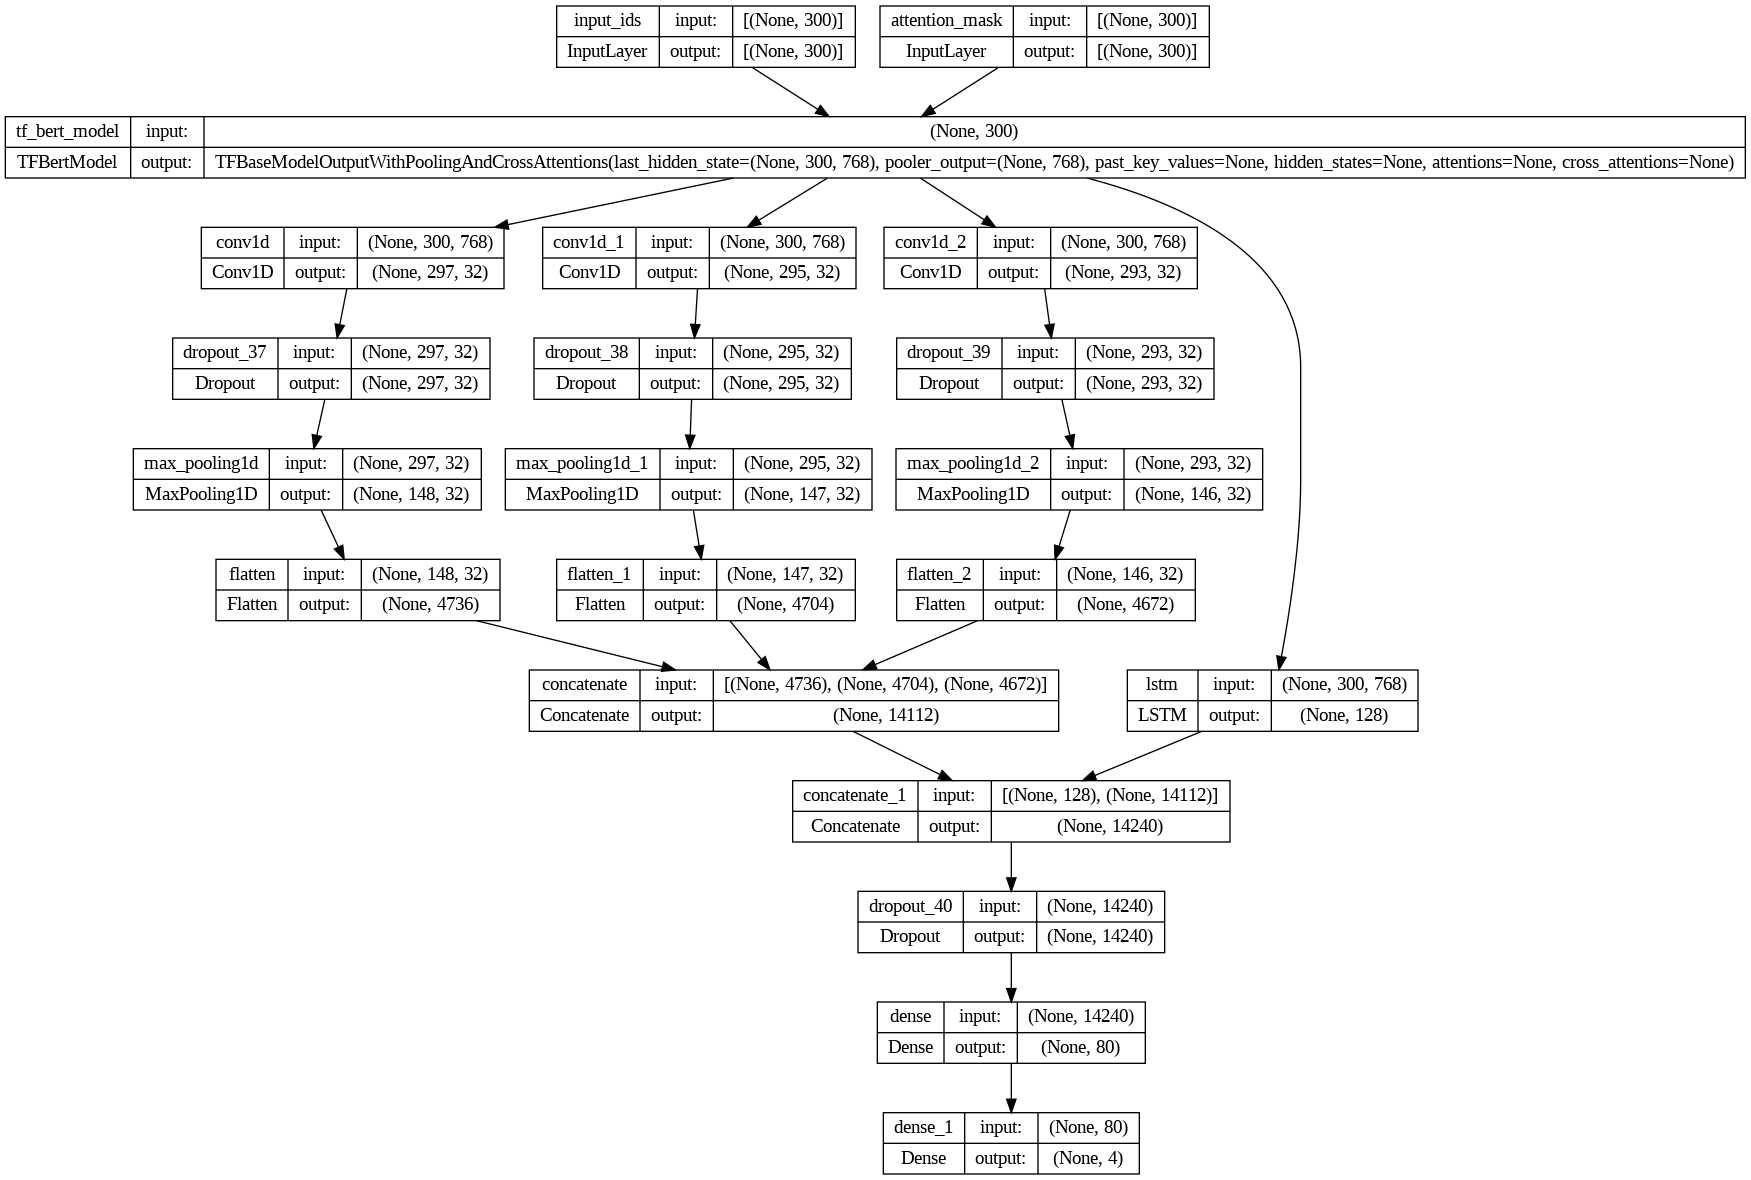

In [ ]:
#plot the vulgar detection model architecture
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='toxic_detection_model_plot.png', show_shapes=True, show_layer_names=True)
Image(retina=True, filename='toxic_detection_model_plot.png')

In [ ]:
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

In [ ]:
history = model.fit(
    train_dataset,
    batch_size=256,
    epochs=6,
    validation_data=dev_dataset,
    validation_steps=20,
    verbose=1)

Epoch 1/6
763/763 [==============================] - 959s 1s/step - loss: 0.3405 - accuracy: 0.6973 - fmeasure: 0.8100 - precision: 0.8116 - recall: 0.8130 - val_loss: 0.2080 - val_accuracy: 0.8250 - val_fmeasure: 0.8925 - val_precision: 0.8793 - val_recall: 0.9074
Epoch 2/6
763/763 [==============================] - 854s 1s/step - loss: 0.2346 - accuracy: 0.7662 - fmeasure: 0.8770 - precision: 0.8780 - recall: 0.8791 - val_loss: 0.1778 - val_accuracy: 0.8125 - val_fmeasure: 0.9027 - val_precision: 0.8967 - val_recall: 0.9105
Epoch 3/6
763/763 [==============================] - 854s 1s/step - loss: 0.1812 - accuracy: 0.8129 - fmeasure: 0.9052 - precision: 0.9061 - recall: 0.9070 - val_loss: 0.1579 - val_accuracy: 0.8188 - val_fmeasure: 0.9194 - val_precision: 0.9255 - val_recall: 0.9153
Epoch 4/6
763/763 [==============================] - 855s 1s/step - loss: 0.1361 - accuracy: 0.8404 - fmeasure: 0.9287 - precision: 0.9280 - recall: 0.9315 - val_loss: 0.1471 - val_accuracy: 0.8500 - va

In [ ]:
model.save_weights("/content/drive/MyDrive/Colab Notebooks/Shafa/MConv_LSTM_BERT")

In [ ]:
test_score = model.evaluate(test_dataset)

print('Test Loss:', test_score[0])
print('Test Accuracy:', test_score[1])

203/203 [==============================] - 77s 381ms/step - loss: 0.1570 - accuracy: 0.8511 - fmeasure: 0.9321 - precision: 0.9398 - recall: 0.9259
Test Loss: 0.1569800078868866
Test Accuracy: 0.8510966897010803


In [ ]:
y_pred = model.predict([X_input_ids_test, X_attn_masks_test])

102/102 [==============================] - 76s 716ms/step


In [ ]:
len(y_test), len(y_pred)

(3237, 3237)

In [ ]:
Threshold = 0.5
upper, lower = 1, 0

In [ ]:
from sklearn.metrics import classification_report
y_pred1 = y_pred
y_true = y_test



y_pred1 = np.where(y_pred >= .5, upper, lower)

print(classification_report(
  y_true,
  y_pred1,
  target_names=LABEL_COLUMNS,
  zero_division=0
))

              precision    recall  f1-score   support

       toxic       0.96      0.92      0.94      1618
      threat       0.80      0.85      0.82       342
     obscene       0.94      0.91      0.93      1447
   religious       0.96      0.96      0.96      1383

   micro avg       0.94      0.93      0.93      4790
   macro avg       0.91      0.91      0.91      4790
weighted avg       0.94      0.93      0.93      4790
 samples avg       0.94      0.93      0.93      4790



In [ ]:
#https://www.kaggle.com/code/kmkarakaya/multi-label-model-evaluation/notebook

from sklearn.metrics import multilabel_confusion_matrix
conf_mat = multilabel_confusion_matrix(y_test, y_pred1)

In [ ]:
def multilabel_accuracies(p):
    TP = p[1][1]
    TN = p[0][0]
    FP = p[0][1]
    FN = p[1][0]
    acc = (TP + TN) / (TP + TN + FP + FN)
    print(acc)

In [ ]:
print("Each label accuracy: ")
for i in range(len(conf_mat)):
    print(LABEL_COLUMNS[i])
    multilabel_accuracies(conf_mat[i])

Each label accuracy: 
toxic
0.9394501081248069
threat
0.9613839975285758
obscene
0.9348161878282361
religious
0.9663268458449181


In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

(0.0, 0.3539243407547474)

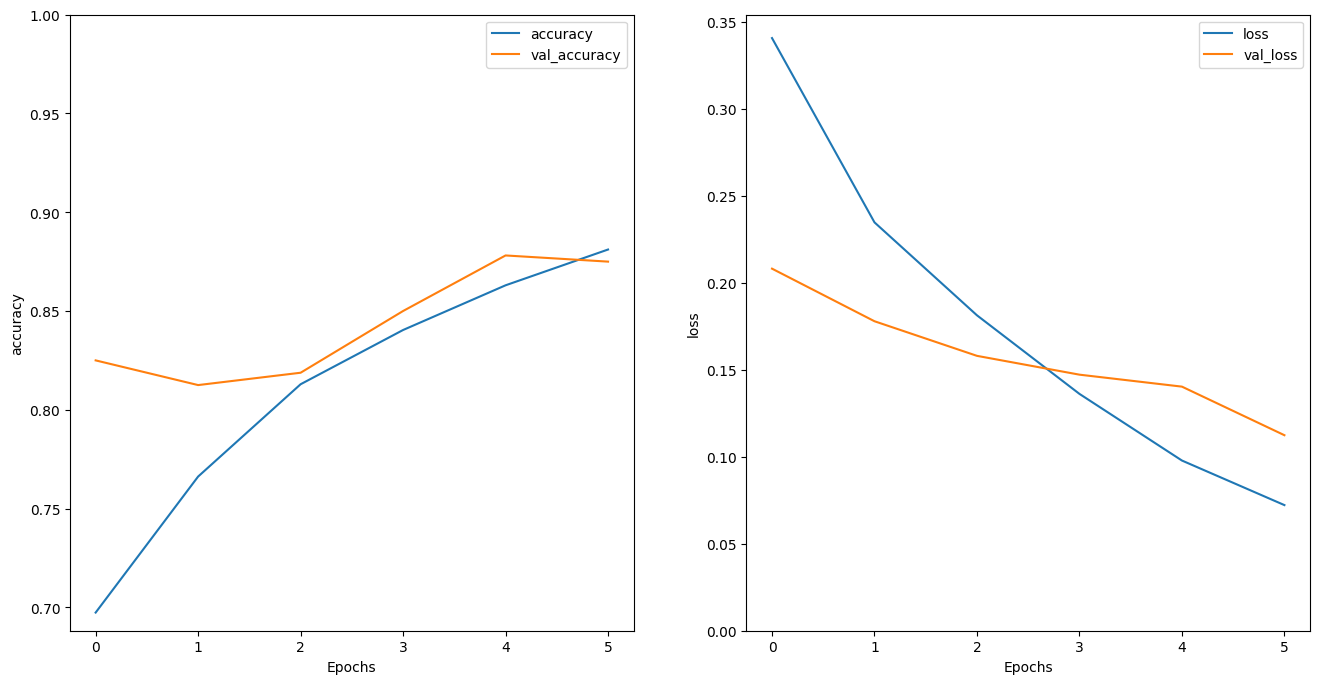

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [ ]:
#model.save_weights("/content/drive/MyDrive/Colab Notebooks/Belal/CNN_LSTM_ATTENTION_BERT_WITH_ATTENTION")

In [ ]:
model1 = model

In [ ]:
model1.load_weights("/content/drive/MyDrive/Colab Notebooks/Shafa/MConv_LSTM_BERT")

In [ ]:
#sample_text = ['খানকির পুলা', 'মেরে সাফা করে ফেল', 'নাটকটা খুব সুন্দর আমার খুব ভাল লেগেছে']
#sample_text = bert_encode(['নাটকটা খুব সুন্দর আমার খুব ভাল লেগেছে'])


In [ ]:
LABEL_COLUMNS

['toxic', 'threat', 'obscene', 'religious']

Predicting New Sentence

In [ ]:
def prepare_data(input_text, tokenizer):
    token = tokenizer.encode_plus(
        input_text,
        max_length=300,
        truncation=True,
        padding='max_length',
        add_special_tokens=True,
        return_tensors='tf'
    )
    return {
        'input_ids': tf.cast(token.input_ids, tf.float64),
        'attention_mask': tf.cast(token.attention_mask, tf.float64)
    }

def make_prediction(model, processed_data, classes=LABEL_COLUMNS):
    probs = model.predict(processed_data)[0]
    return np.where(probs >= Threshold, upper, lower)

input_text = clean_doc('খানকি মাগী বের হয়ে যা')
processed_data = prepare_data(input_text, tokenizer)
result = make_prediction(model, processed_data=processed_data)
print(f"Classification results: {result}")

1/1 [==============================] - 5s 5s/step
Classification results: [1 0 1 0]
